In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pickle
from alternative_ford import bellman_ford, greedy_ford, decay_ford
import seaborn as sns

Notebook to generate Figure 5 from the paper, including correlations between true and predicted distances, and
dependency on the distance to source

In [18]:
data = np.load('value_gen_graphs/trajs_softmax.npz', allow_pickle=True)
# data = np.load('../trajs.npz', allow_pickle=True)
inputs = data['inputs']
score = data['score']
lengths = data['lengths']
trajs = data['trajs']
outputs = data['outputs']
hints = data['hints']


# with open('../trajs.pkl', 'rb') as handle:
#     data = pickle.load(handle)
#
# feedback = data['feedback']
# score = data['score']['pi']
# trajs = data['trajs']
# outputs = feedback.outputs
# hints = feedback.features.hints
# inputs = feedback.features.inputs
# lengths = feedback.features.lengths

In [19]:
idx = np.random.choice(np.where(score == np.min(score))[0])

idx

3631

In [20]:
score[idx]

0.75

In [21]:
graph = nx.from_numpy_array(inputs[2].data[idx,:, :])
graph: nx.Graph

n = 64
nodes = np.arange(n)

In [22]:
graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63))

In [ ]:
def draw(step):
    preds = np.argmax(hints[step]['pi_h'][idx], axis=1)
    dist = hints[step]['d'][idx]
    true_pi = outputs[0].data[idx]
    chk_edge = lambda x, u, v: x[u]==v or x[v]==u

    pos = nx.shell_layout(graph)

    cmap = ['red' if inputs[1].data[idx,i] == 1.0 else 'gray' for i in nodes]
    edge_colors = ['green' if chk_edge(true_pi,u,v) and chk_edge(preds,u,v) else
                   'red' if chk_edge(preds,u,v) else
                   'blue' if chk_edge(true_pi,u,v) else
                   'black' for (u, v) in graph.edges]

    plt.figure()

    nx.draw(graph, pos, node_color=cmap, edge_color=edge_colors, arrows=True)
    nx.draw_networkx_labels(graph, pos, {i:f"{i}\n{dist[i]:.2f}" for i in nodes})
    edge_dict = {(i,j):np.round(inputs[2].data[idx,i,j], decimals=2) for i in nodes for j in nodes}
    nx.draw_networkx_edge_labels(graph, pos, {k:v for k,v in edge_dict.items() if v > 0 and k[0] != k[1]})

    plt.suptitle(f"Step {step+1}")
    plt.savefig(f'series/graph_{step}.png',dpi=400)

    pass

In [ ]:
for i in range(lengths[idx]):
    draw(i)

In [ ]:
# decay_ford(A=inputs[2].data[idx,:, :], s=np.argmax(inputs[1].data[idx]).item())

In [23]:
preds = [np.argmax(hints[step]['pi_h'][idx], axis=1) for step in range(len(hints))]
preds[:lengths[idx]]

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 23, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 40, 36, 37, 38, 39, 23, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 40, 36, 37, 38, 39, 23, 41, 42, 35, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 35, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 53, 12, 13, 14, 15, 16,
        17, 18,

In [24]:
n = inputs[0].data.shape[0]
allpreds = np.array([np.argmax(hints[-1]['pi_h'][i], axis=1) for i in range(n)])
allAs = [inputs[2].data[i, ...] for i in range(n)]
allss = [np.argmax(inputs[1].data[i, ...]) for i in range(n)]

In [25]:
bf_out = [bellman_ford(allAs[i], allss[i], 15) for i in range(n)]

In [26]:
true_preds = np.array([bf_out[i][0][-1] for i in range(n)])
dists = np.array([bf_out[i][1] for i in range(n)])

In [27]:
np.count_nonzero(allpreds != true_preds) / np.shape(allpreds.reshape(-1,1))[0]

0.04265594482421875

In [28]:
true_preds.shape

(4096, 64)

In [29]:
allpreds

array([[21, 52, 28, ..., 19, 20, 39],
       [ 5, 49, 51, ...,  5, 30, 12],
       [56, 32, 20, ..., 27, 44, 42],
       ...,
       [20, 39, 32, ..., 39, 49, 39],
       [42, 21, 10, ..., 63, 56, 21],
       [24, 57, 41, ..., 26, 45, 58]], dtype=int64)

In [30]:
true_preds

array([[21, 52, 28, ..., 19, 20, 39],
       [ 5, 49, 51, ...,  5, 30, 12],
       [56, 32, 20, ..., 27, 44, 42],
       ...,
       [20, 39, 32, ..., 39, 49, 39],
       [42, 21, 10, ..., 63, 56, 21],
       [24, 57, 41, ..., 26, 45, 58]])

C:\Users\Vlamir\AppData\Local\Temp\ipykernel_31696\3139991431.py:15: RuntimeWarning: invalid value encountered in divide
  ax[0][1].plot(bins[:bin], (false_counts / (true_counts + false_counts))[:bin])
C:\Users\Vlamir\AppData\Local\Temp\ipykernel_31696\3139991431.py:31: RuntimeWarning: invalid value encountered in divide
  ax[1][1].plot(bins[:bin], (false_counts / (true_counts + false_counts))[:bin])


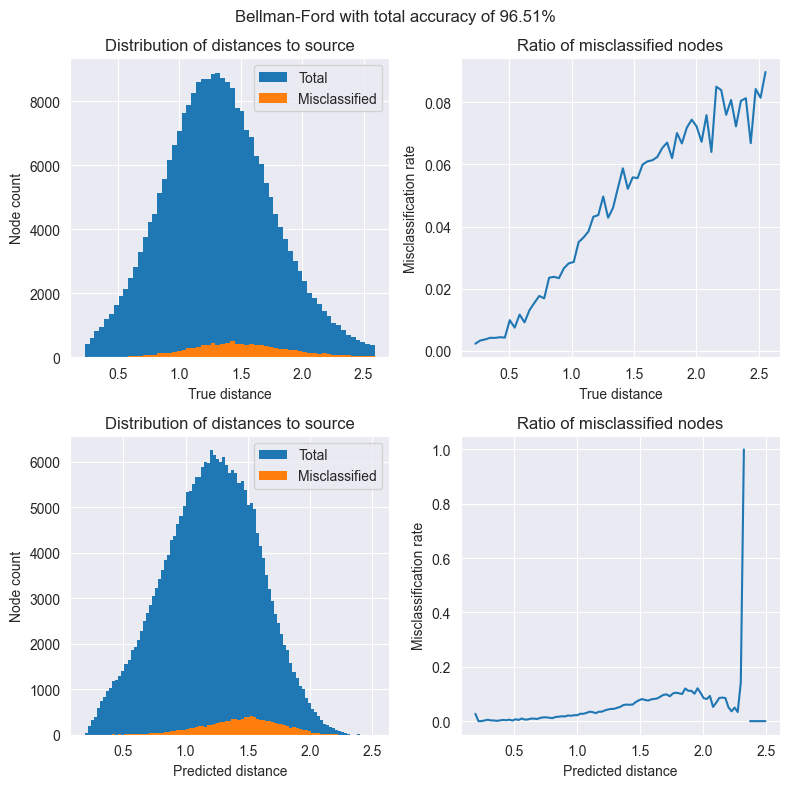

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
bin = 60

true_counts, bins = np.histogram(dists[(true_preds == allpreds) & (dists > 0)], bins=100)
false_counts, bins = np.histogram(dists[(true_preds != allpreds) & (dists > 0)], bins=100)
total_counts = true_counts + false_counts

ax[0][0].set_title("Distribution of distances to source")
ax[0][0].stairs(total_counts[:bin], bins[:bin + 1], fill=True, label='Total')
ax[0][0].stairs(false_counts[:bin], bins[:bin + 1], fill=True, label='Misclassified')
ax[0][0].set_xlabel("True distance")
ax[0][0].set_ylabel("Node count")
ax[0][0].legend()
ax[0][1].set_title("Ratio of misclassified nodes")
ax[0][1].plot(bins[:bin], (false_counts / (true_counts + false_counts))[:bin])
ax[0][1].set_xlabel("True distance")
ax[0][1].set_ylabel("Misclassification rate")

true_counts, bins = np.histogram(hints[-1]['d'][(true_preds == allpreds) & (dists > 0)], bins=100)
false_counts, bins = np.histogram(hints[-1]['d'][(true_preds != allpreds) & (dists > 0)], bins=100)
total_counts = true_counts + false_counts
bin = 95

ax[1][0].set_title("Distribution of distances to source")
ax[1][0].stairs(total_counts[:bin], bins[:bin + 1], fill=True, label='Total')
ax[1][0].stairs(false_counts[:bin], bins[:bin + 1], fill=True, label='Misclassified')
ax[1][0].set_xlabel("Predicted distance")
ax[1][0].set_ylabel("Node count")
ax[1][0].legend()
ax[1][1].set_title("Ratio of misclassified nodes")
ax[1][1].plot(bins[:bin], (false_counts / (true_counts + false_counts))[:bin])
ax[1][1].set_xlabel("Predicted distance")
ax[1][1].set_ylabel("Misclassification rate")


fig.suptitle(f'Bellman-Ford with total accuracy of {100*np.mean(score):.2f}%')
fig.tight_layout()
# fig.savefig('distance_distrib.png', dpi=400)
pass

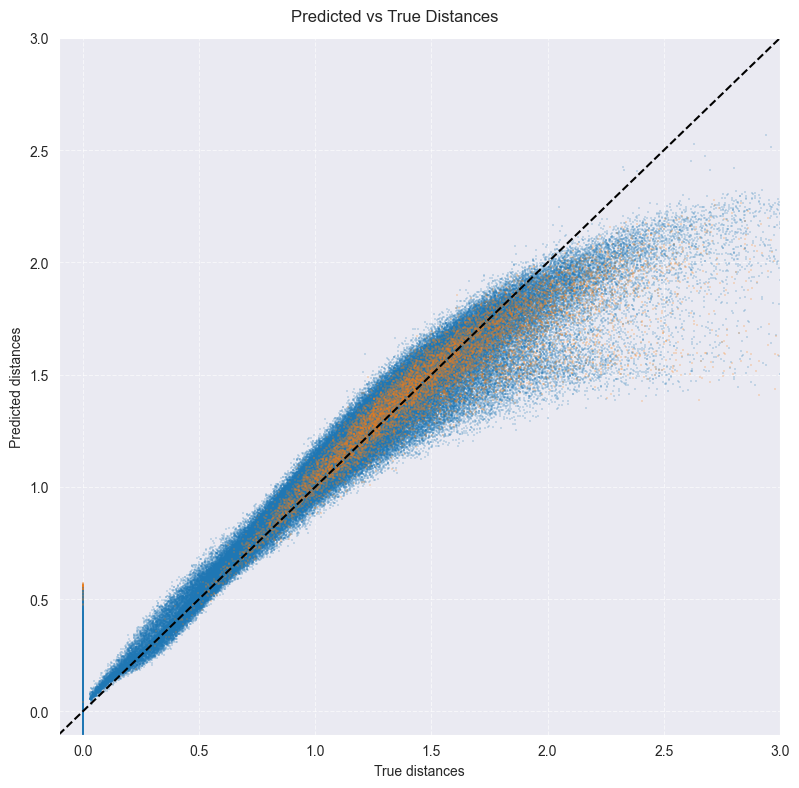

In [32]:
plt.figure(figsize=(8,8))
plt.suptitle('Predicted vs True Distances')
plt.scatter(dists[true_preds == allpreds], hints[-1]['d'][true_preds == allpreds], s=1, marker=',', alpha=0.2, lw=0)
plt.scatter(dists[true_preds != allpreds], hints[-1]['d'][true_preds != allpreds], s=1, marker=',', alpha=0.2, lw=0)
plt.xlabel('True distances')
plt.ylabel('Predicted distances')
plt.grid(alpha=0.6, linestyle='--')
plt.tight_layout()
l = hints[-1]['d'].min()
r = max(1, min(dists.max(), 3))
plt.xlim([l, r])
plt.ylim([l, r])
plt.plot([l, r], [l, r], c='black', linestyle='--')
# plt.savefig('dist_correlation.png', dpi=400)
pass

C:\Users\Vlamir\AppData\Local\Temp\ipykernel_31696\2417844534.py:19: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(bins[1:][filter], (false_counts / (true_counts + false_counts))[filter])


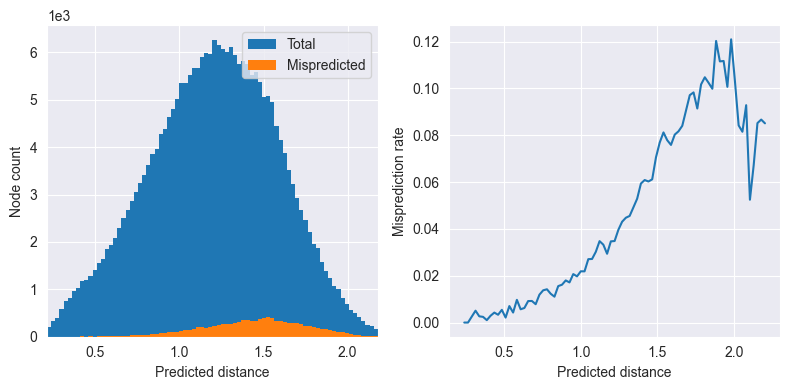

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

true_counts, bins = np.histogram(hints[-1]['d'][(true_preds == allpreds) & (dists > 0)], bins=100)
false_counts, bins = np.histogram(hints[-1]['d'][(true_preds != allpreds) & (dists > 0)], bins=100)
total_counts = true_counts + false_counts

# ax[0].set_title("Distribution of distances to source")
ax[0].stairs(total_counts, bins, fill=True, label='Total')
ax[0].stairs(false_counts, bins, fill=True, label='Mispredicted')
ax[0].set_xlim(min(bins[:-1][total_counts > 100]), max(bins[:-1][total_counts > 100]))
ax[0].set_xlabel("Predicted distance")
ax[0].ticklabel_format(axis='y', scilimits=(0,0))

ax[0].set_ylabel("Node count")
ax[0].legend()

# ax[1].set_title("Ratio of misclassified nodes")
filter = total_counts > 100
ax[1].plot(bins[1:][filter], (false_counts / (true_counts + false_counts))[filter])
ax[0].set_xlim(min(bins[:-1][total_counts > 100]), max(bins[:-1][total_counts > 100]))
ax[1].set_xlabel("Predicted distance")
ax[1].set_ylabel("Misprediction rate")

# ax[2].scatter(dists[true_preds == allpreds], hints[-1]['d'][true_preds == allpreds], s=1, marker=',', alpha=0.2, lw=0)
# ax[2].scatter(dists[true_preds != allpreds], hints[-1]['d'][true_preds != allpreds], s=1, marker=',', alpha=0.2, lw=0)
# ax[2].set_xlabel('True distances')
# ax[2].set_ylabel('Predicted distances')
# ax[2].grid(alpha=0.6, linestyle='--')
# l = hints[-1]['d'].min()
# r = max(1, min(dists.max(), 3))
# ax[2].set_xlim([l, r])
# ax[2].set_ylim([l, r])
# ax[2].plot([l, r], [l, r], c='black', linestyle='--', lw=1)

fig.tight_layout()
fig.savefig('plots_final/distrib_soft.png', dpi=400)
pass